In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from scipy.optimize import curve_fit

# # Simulation parameters
# B_min_values = np.linspace(.01, .1, 10)
# T_values = np.linspace(4, 20, 20)
# g = 1
# steps = 10
# omegas = np.linspace(0, 3, 20)
# B_factors = [0, 1.0, 2.0]
# threshold_offsets = np.linspace(-0.01, 0.01, 10)


B_min_values = np.logspace(-3, -1, 20)
T_values = np.logspace(-1, 2, 20)
g = 1
steps = 50
omegas = np.linspace(0, 10, 20)
B_factors = [0, 1.0, 2.0]
threshold_offsets = np.linspace(-0.01, 0.01, 20)

# Define n-qubit GHZ state
def ghz_state(n):
    return (tensor([basis(2, 0) for _ in range(n)]) + tensor([basis(2, 1) for _ in range(n)])).unit()

def collective_op(op, n):
    return tensor([op for _ in range(n)])

def local_sum_op(op, n):
    return sum([tensor([identity(2)] * i + [op] + [identity(2)] * (n - i - 1)) for i in range(n)])

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

def ghl_model(B_min, c, d):
    return c / B_min**1.5 + d

# Run the simulation
qubit_counts = [1, 3, 5, 7, 9]
results_by_n = {}

for n_qubits in qubit_counts:
    print(f"\n=== Running for {n_qubits} qubit(s) ===")
    csx_n = collective_op(sigmax(), n_qubits)
    csz_n = collective_op(sigmaz(), n_qubits)
    sx_n = local_sum_op(sigmax(), n_qubits)
    sz_n = local_sum_op(sigmaz(), n_qubits)
    psi0 = ghz_state(n_qubits)
    min_time_for_B = []

    # Debug vars for last B_min
    last_TPRs = []
    last_TNRs = []
    last_offsets = []

    for B_min in tqdm(B_min_values):
        success_T = None
        last_results = {}

        for T in T_values:
            times = np.linspace(0, T, steps)
            results = {}

            for B_mult in B_factors:
                B = B_mult * B_min
                estimates = []
                for omega in omegas:
                    H0 = g * sx_n
                    H1 = [sz_n, lambda t, args: B * np.cos(omega * t)]
                    H = [H0, H1]
                    result = mesolve(H, psi0, times, [], [csz_n, csx_n])
                    z_vals, x_vals = result.expect[0], result.expect[1]
                    est = estimate_signal_strength(z_vals, x_vals)
                    estimates.append(est)
                results[B] = np.var(estimates)

            baseline_var = results[0.0]

            for offset in threshold_offsets:
                threshold = baseline_var + offset
                tp = tn = tp_total = tn_total = 0

                for B_mult in B_factors:
                    B = B_mult * B_min
                    var = results[B]
                    decision = "H1" if var > threshold else "H0"
                    if B_mult == 0:
                        tn_total += 1
                        if decision == "H0":
                            tn += 1
                    elif B_mult >= 1.0:
                        tp_total += 1
                        if decision == "H1":
                            tp += 1

                tpr = tp / tp_total if tp_total else 0
                tnr = tn / tn_total if tn_total else 0

                # Store for debugging the last B_min only
                if B_min == B_min_values[-1]:
                    last_TPRs.append(tpr)
                    last_TNRs.append(tnr)
                    last_offsets.append(offset)

                if tpr >= 0.9 and tnr >= 0.9:
                    success_T = T
                    break

            if success_T:
                break

        min_time_for_B.append(success_T if success_T else np.nan)

    results_by_n[n_qubits] = {
        "B_min_values": B_min_values.copy(),
        "min_times": np.array(min_time_for_B)
    }



=== Running for 1 qubit(s) ===


100%|███████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]



=== Running for 3 qubit(s) ===


100%|███████████████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]



=== Running for 5 qubit(s) ===


100%|███████████████████████████████████████████| 20/20 [00:36<00:00,  1.81s/it]



=== Running for 7 qubit(s) ===


100%|███████████████████████████████████████████| 20/20 [01:03<00:00,  3.19s/it]



=== Running for 9 qubit(s) ===


100%|███████████████████████████████████████████| 20/20 [02:46<00:00,  8.34s/it]


In [19]:
results_by_n

{1: {'B_min_values': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
         0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
         0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
         0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ]),
  'min_times': array([        nan,         nan,         nan,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
         33.59818286, 23.35721469, 16.23776739, 11.28837892,  7.8475997 ,
          5.45559478,  3.79269019,  2.6366509 ,  2.6366509 ,  1.83298071])},
 3: {'B_min_values': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
         0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
         0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
         0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ]),
  'min_times': array([        nan,         nan,         nan,         nan,         nan,
       

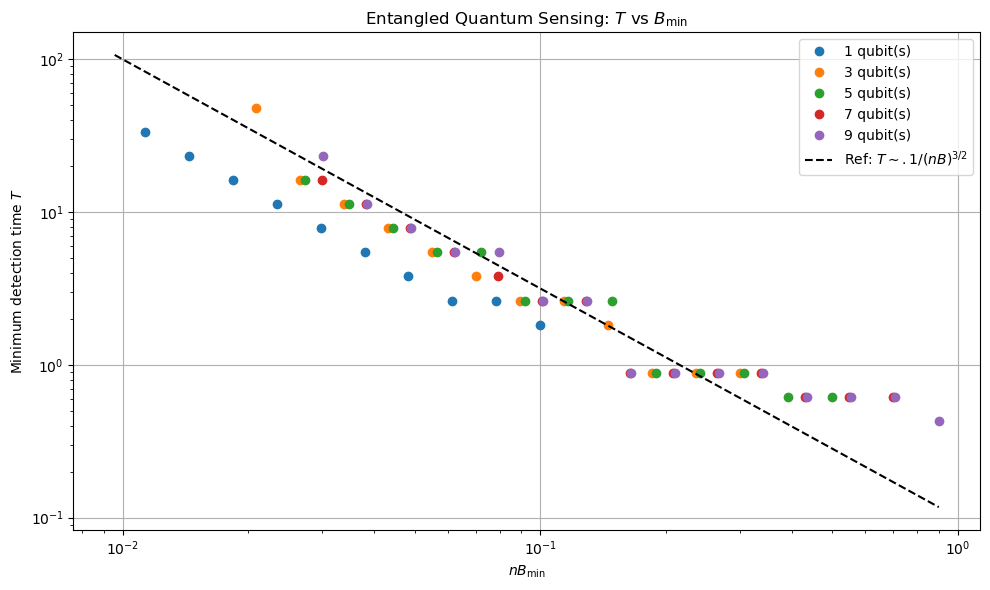

In [30]:
# Main Plot: Minimum Detection Time vs B_min
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
fits = {}

for i, n in enumerate(qubit_counts):
    B_vals = n * results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    B_fit = B_vals[valid]
    T_fit = T_vals[valid]

    plt.plot(B_vals, T_vals, 'o', label=f'{n} qubit(s)')

# Reference line: T ~ 1 / B^{3/2}
B_ref = np.logspace(np.log10(min(B_fit))-.5, np.log10(max(B_fit)), 200)
T_ref = .1 / B_ref**1.5
plt.plot(B_ref, T_ref, 'k--', label=r'Ref: $T \sim .1 / (nB)^{3/2}$')

plt.xlabel(r'$nB_{\min}$')
plt.ylabel(r'Minimum detection time $T$')
plt.title(r'Entangled Quantum Sensing: $T$ vs $B_{\min}$')
plt.grid(True)
plt.loglog()
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# === CONFIGURATION ===
tail_order = 5# Number of Taylor series terms to fit in the tail

# === Define dynamic model generator ===
def make_improved_model(tail_order):
    def model(X, *params):
        B, n = X
        a = params[0]
        tail_terms = params[1:]
        result = a / (n * B)**1.5
        for i, coeff in enumerate(tail_terms):
            result += coeff / n**i
        return result
    return model

# === Fit the model ===
model_func = make_improved_model(tail_order)
num_params = 1 + tail_order + 1  # a + (b + c/n + ...), including 1/n^0 term
initial_guess = [1] * num_params
bounds = ([-10]*num_params, [10]*num_params)

# Fit using curve_fit
popt, _ = curve_fit(
    model_func,
    (all_B, all_n),
    all_T,
    p0=initial_guess,
    bounds=bounds,
    maxfev=10000
)

# === Print fitted parameters ===
print("✅ Improved joint fit parameters:")
print(f"    a = {popt[0]:.4f}")
for i in range(1, num_params):
    print(f"    x{i-1} = {popt[i]:.4f}")
term_str = " + ".join([f"{popt[i]:.2f}/n^{i-1}" for i in range(1, num_params)])
print(f"    Model: T(B, n) = {popt[0]:.2f}/(n B)^1.5 + {term_str}")

# === Plot the fit across B for each n ===
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i, n in enumerate(qubit_counts):
    B_vals = results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    B_fit = B_vals[valid]
    T_fit = T_vals[valid]

    B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
    T_smooth = model_func((B_smooth, np.full_like(B_smooth, n)), *popt)

    plt.plot(B_fit, T_fit, 'o', label=f'{n} qubit(s) data')
    plt.plot(B_smooth, T_smooth, '--', color=colors[i % len(colors)],
             label=f'{n}q fit')

plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title(f'Joint Fit with Qubit-Dependent Offset (Up to $1/n^{tail_order}$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot the Taylor tail shape f(x) ===
def taylor_tail_x(x, coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

x_vals = np.linspace(0, 1, 500)  # x = 1/n
tail_coeffs = popt[1:]  # all except 'a'
tail_vals = taylor_tail_x(x_vals, tail_coeffs)

plt.figure(figsize=(8, 5))
label_terms = " + ".join([f"{c:.2f}·x^{i}" for i, c in enumerate(tail_coeffs)])
plt.plot(x_vals, tail_vals, label='Tail approx:\n' + label_terms)
plt.xlabel('$x = 1/n$')
plt.ylabel('Tail value $f(x)$')
plt.title(f'Shape of Taylor Series Tail Near $x = 0$ (Order {tail_order})')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'all_B' is not defined

In [197]:
def plot_taylor_coefficients(coeffs):
    """
    Plots the Taylor expansion coefficients as a bar chart.
    
    Args:
        coeffs (list or array): Taylor series coefficients [x0, x1, ..., xN]
    """
    orders = np.arange(len(coeffs))
    
    plt.figure(figsize=(8, 4))
    plt.bar(orders, coeffs)
    for i, c in enumerate(coeffs):
        plt.text(i, c, f'{c:.2f}', ha='center', va='bottom' if c >= 0 else 'top', fontsize=9)
    
    plt.xlabel('Order (i in $x^i$)')
    plt.ylabel('Coefficient value')
    plt.title('Taylor Series Coefficients for Tail Function')
    plt.grid(True, axis='y')
    plt.xticks(orders)
    plt.tight_layout()
    plt.show()


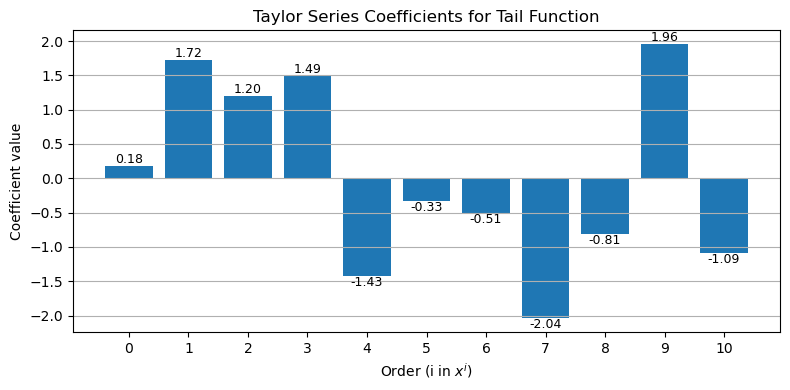

In [198]:
plot_taylor_coefficients(tail_coeffs)


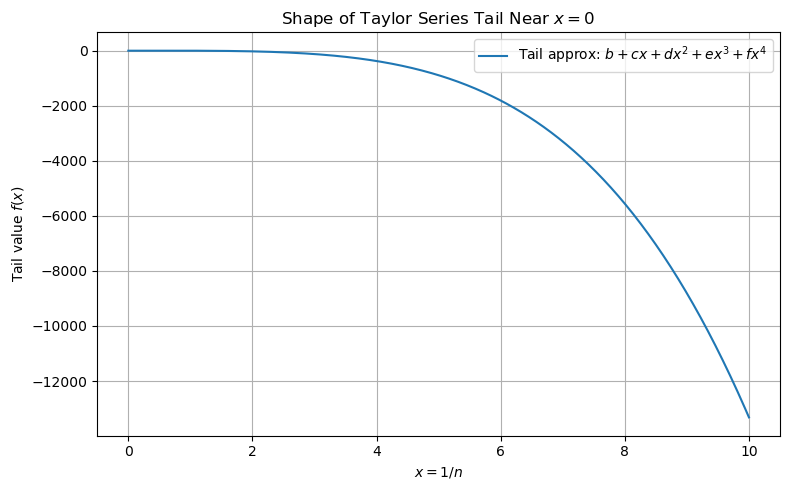

In [192]:
# Define the Taylor polynomial in terms of x = 1/n
def taylor_tail_x(x, b, c, d, e, f):
    return b + c*x + d*x**2 + e*x**3 + f*x**4

# Generate small x values near 0 (e.g., x = 1/n for large n)
x_vals = np.linspace(0, 10, 500)  # 1/n with n from 10 to ∞

# Evaluate the function
tail_vals = taylor_tail_x(x_vals, b_fit, c_fit, d_fit, e_fit, f_fit)

# Plot the Taylor polynomial near x = 0
plt.figure(figsize=(8, 5))
plt.plot(x_vals, tail_vals, label='Tail approx: $b + cx + dx^2 + ex^3 + fx^4$')
plt.xlabel('$x = 1/n$')
plt.ylabel('Tail value $f(x)$')
plt.title('Shape of Taylor Series Tail Near $x = 0$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
